In [1]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: keras-applications, numpy, opt-einsum, tensorboard, absl-py, keras-preprocessing, gast, wrapt, termcolor, six, protobuf, wheel, astor, grpcio, tensorflow-estimator, google-pasta
Required-by: kapre


In [2]:
!pip install tensorflow==1.15
import tensorflow as tf
import os 
import glob 
import xml.etree.ElementTree as ET 
import pandas as pd

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [5]:
!git clone --q https://github.com/tensorflow/models.git

In [6]:
#navigate to /models/research folder to compile protos 
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf1/setup.py . 
!python -m pip install .

/content/models/research
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 352 kB 12.0 MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1683139 sha256=6fc7e040c61598563fe759171e14cb45efaa8e7449728e9f08e6fa94bf20dc16
  Stored in directory: /tmp/pip-ephem-wheel-cache-_q6ghc_e/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection


In [7]:
!python object_detection/builders/model_builder_tf1_test.py

Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_model_from_config_w

In [ ]:
%cd /mydrive/SSD/data/

/content/gdrive/My Drive/SSD/data


In [ ]:
!unzip /mydrive/SSD/images.zip -d . 
!unzip /mydrive/SSD/annotations.zip -d .

Archive:  /mydrive/SSD/images.zip
   creating: ./images/
  inflating: ./images/0-with-mask.jpg  
  inflating: ./images/0.jpg          
  inflating: ./images/1-with-mask.jpg  
  inflating: ./images/10-with-mask.jpg  
  inflating: ./images/100-with-mask.jpg  
  inflating: ./images/101-with-mask.jpg  
  inflating: ./images/103-with-mask.jpg  
  inflating: ./images/104-with-mask.jpg  
  inflating: ./images/105-with-mask.jpg  
  inflating: ./images/106-with-mask.jpg  
  inflating: ./images/107-with-mask.jpg  
  inflating: ./images/108-with-mask.jpg  
  inflating: ./images/109-with-mask.jpg  
  inflating: ./images/11-with-mask.jpg  
  inflating: ./images/110-with-mask.jpg  
  inflating: ./images/111-with-mask.jpg  
  inflating: ./images/112-with-mask.jpg  
  inflating: ./images/113-with-mask.jpg  
  inflating: ./images/114-with-mask.jpg  
  inflating: ./images/115-with-mask.jpg  
  inflating: ./images/116-with-mask.jpg  
  inflating: ./images/117-with-mask.jpg  
  inflating: ./images/118-wit

In [ ]:
!pwd

/content/gdrive/My Drive/SSD/data


In [ ]:
!mkdir test_labels train_labels
!ls annotations/* | sort -R | head -250 | xargs -I{} mv {} test_labels/
!ls annotations/* | xargs -I{} mv {} train_labels/

mkdir: cannot create directory ‘test_labels’: File exists
mkdir: cannot create directory ‘train_labels’: File exists


In [ ]:
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,       
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.
Successfully created label_map.pbtxt 


In [ ]:
#!python generate_tfrecord.py output.csv output_pb.txt /path/to/images output.tfrecords#FOR train.record 
!python /mydrive/SSD/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record
!python /mydrive/SSD/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record

groups: 100% 870/870 [00:02<00:00, 302.88it/s]
Successfully created the TFRecords: /content/gdrive/My Drive/SSD/data/train.record
groups: 100% 500/500 [00:01<00:00, 281.25it/s]
Successfully created the TFRecords: /content/gdrive/My Drive/SSD/data/test.record


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz 
!tar -xzvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

--2021-12-07 16:03:20--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187925923 (179M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’

ssd_mobilenet_v2_co 100%[===================>] 179.22M  58.2MB/s    in 3.2s    

2021-12-07 16:03:23 (56.0 MB/s) - ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’ saved [187925923/187925923]

ssd_mobilenet_v2_coco_2018_03_29/checkpoint
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.meta
ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
ssd_mobilenet_v2_coco_2018_03_29/saved_model/saved_model.pb
ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
ssd_mobilenet_v2_coco_2018_03_29/saved_model/
ssd_mobilenet_v2_coco_2018_03_29/saved_mod

In [ ]:
%load_ext tensorboard 
%tensorboard --logdir '/content/gdrive/MyDrive/SSD/training'

In [ ]:
%cd /content/models/research/object_detection

/content/models/research/object_detection


In [ ]:
!python model_main.py --pipeline_config_path=/mydrive/SSD/data/ssd_mobilenet_v2_coco.config --model_dir=/mydrive/SSD/training --num_train_steps=200000 --sample_1_of_n_eval_examples=1 --alsologtostderr

W1210 12:57:29.691264 140673690302336 model_lib.py:820] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 200000
I1210 12:57:29.691655 140673690302336 config_util.py:552] Maybe overwriting train_steps: 200000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1210 12:57:29.691820 140673690302336 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I1210 12:57:29.691990 140673690302336 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1210 12:57:29.692144 140673690302336 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1210 12:57:29.692330 140673690302336 model_lib.py:836] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_

In [ ]:
%cd /content/models/research/object_detection/

/content/models/research/object_detection


In [ ]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path /mydrive/SSD/data/ssd_mobilenet_v2_coco.config --trained_checkpoint_prefix /mydrive/SSD/training/model.ckpt-21409 --output_directory /mydrive/SSD/data/inference_graph

Instructions for updating:
Please use `layer.__call__` method instead.
W1212 12:17:29.752240 139705616103296 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1212 12:17:32.475812 139705616103296 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1212 12:17:32.527103 139705616103296 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1212 12:17:32.575251 139705616103296 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [8]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from google.colab.patches import cv2_imshow

# Define the video stream
# cap = cv2.VideoCapture(0)  # Change only if you have more than one webcams


# What model to download.
# Models can bee found here: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
MODEL_NAME = '/content/gdrive/MyDrive/SSD/data/inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_CKPT = os.path.join(os.path.abspath("/content/gdrive/MyDrive/SSD/data/inference_graph"), "frozen_inference_graph.pb")

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/gdrive/MyDrive/SSD/data/label_map.pbtxt'

# Number of classes to detect
NUM_CLASSES = 2

# Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


# Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# Helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


# Detection

            


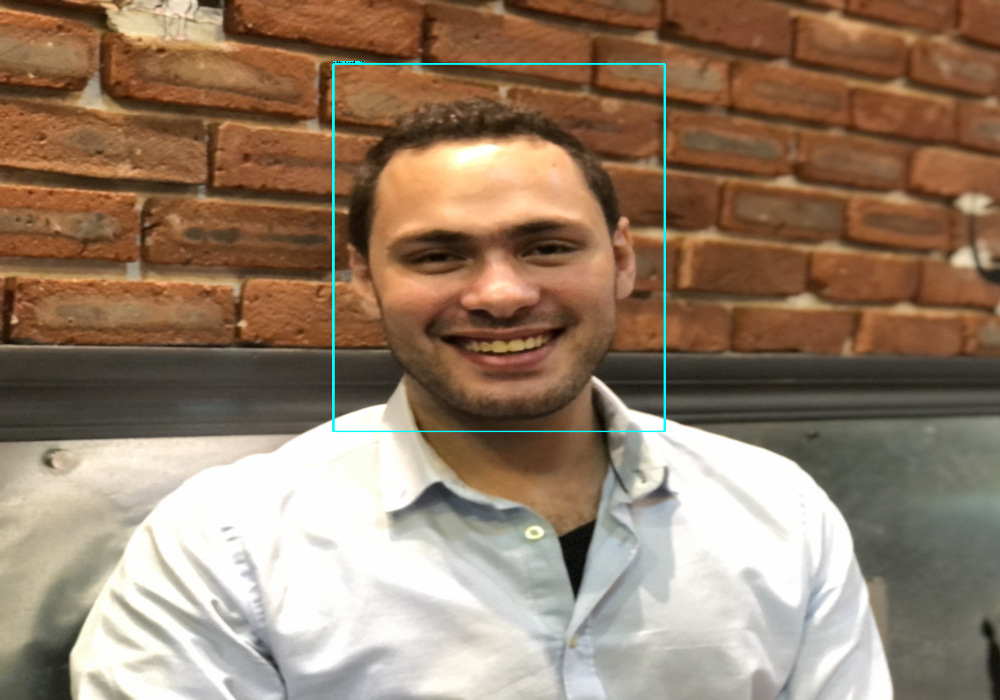

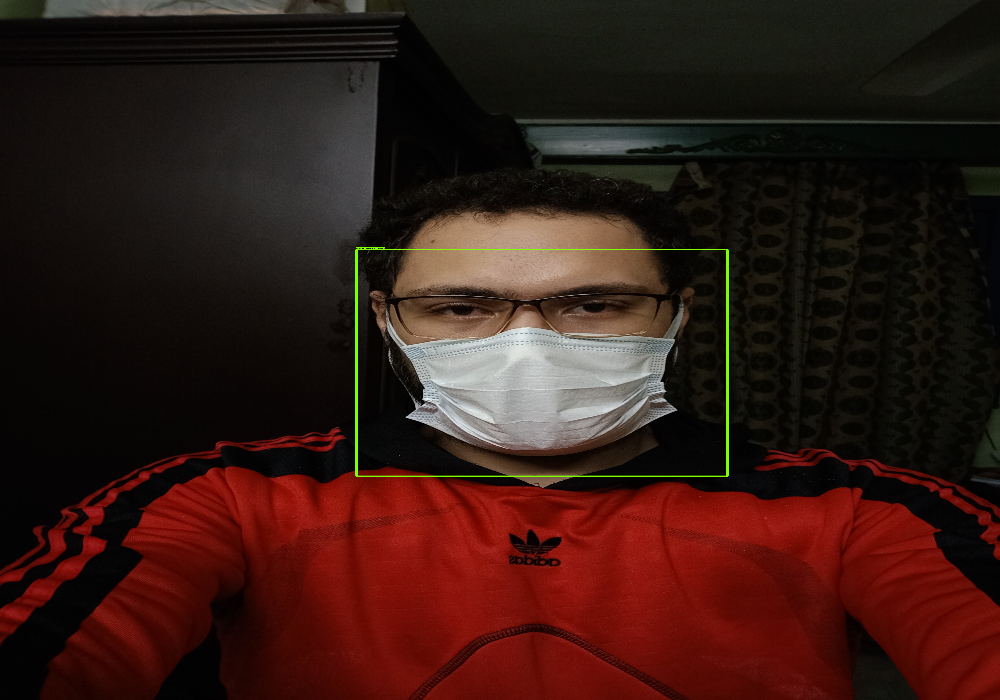

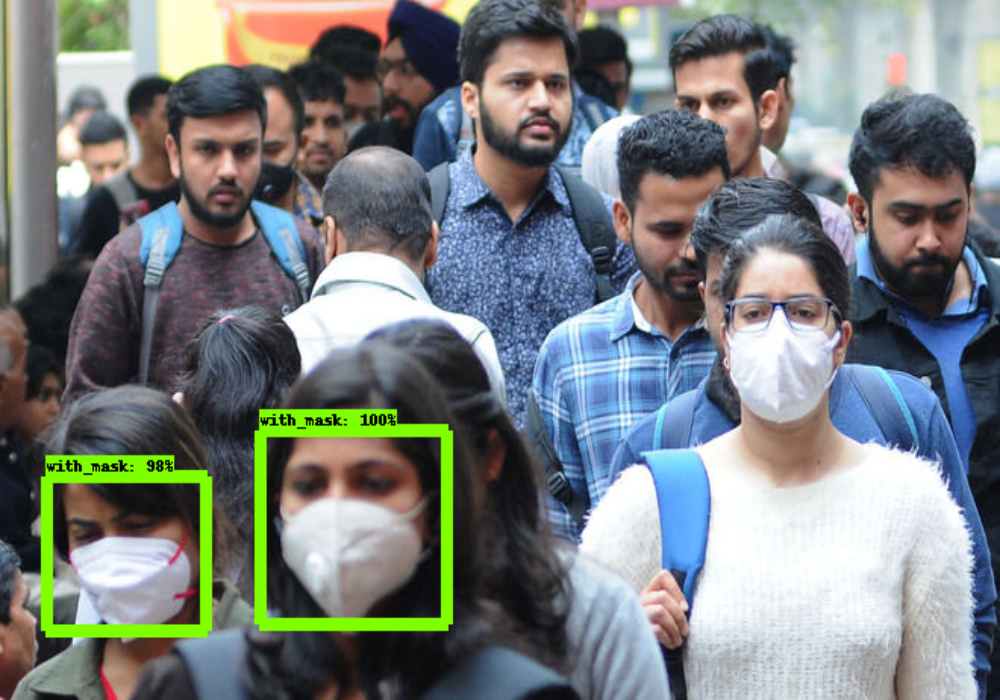

In [13]:
IMAGE_DIR = '/content/gdrive/MyDrive/SSD/data'
IMAGE_PATHS = []
for file in os.listdir(IMAGE_DIR):
  if file.endswith('.jpg'):
    IMAGE_PATHS.append(os.path.join(IMAGE_DIR,file))


with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        for image_np in IMAGE_PATHS:

            image = Image.open(image_np)
            # Conver the image to numpy array
            image_np = load_image_into_numpy_array(image)
            # Read frame from camera
            # ret, image_np = cap.read()
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Extract image tensor
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Extract detection boxes
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Extract detection scores
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            # Extract detection classes
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            # Extract number of detectionsd
            num_detections = detection_graph.get_tensor_by_name(
                'num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8,
                min_score_thresh=0.8)
            img=cv2.resize(image_np, (1000, 700))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Display output
            cv2_imshow(img)

